In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry
import matplotlib.pyplot as plt
import os
import glob
import seaborn as sns

In [2]:
# Check if this file is Mounted to the right folder
# Otherwise, set it to the desired working directory

working_directory = os.getcwd()
desired_directory = '/content/drive/Shareddrives/DAT 490 Capstone/DAT 490 Capstone/EDA'

if working_directory != desired_directory:
  print("Mounting Drive ...\n")
  # mount Google Drive so Collab can access the dataset
  from google.colab import drive
  drive.mount('/content/drive', force_remount = True)

  # set the working directory
  %cd /content/drive/Shareddrives/'DAT 490 Capstone'/'DAT 490 Capstone'/EDA/
else:
  print(f"Working directory set to {desired_directory}")

Mounting Drive ...

Mounted at /content/drive
/content/drive/Shareddrives/DAT 490 Capstone/DAT 490 Capstone/EDA


In [3]:
# Get the county geometries

target_epsg = 'EPSG:5070'
target_epsg = 'EPSG:3857'
the_crs = target_epsg

url_county = 'https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_county_500k.zip'

#And grab:
county_gdf = gpd.read_file(url_county)

# If there are invalid geometries, fix them
county_gdf.geometry = county_gdf.geometry.buffer(0)

# Exclude certain states/territories
exclude_list = ['15', '02', '72', '60', '66', '69', '78']
county_gdf = county_gdf.loc[~county_gdf['STATEFP'].isin(exclude_list)]

county_gdf_5070 = county_gdf.to_crs(target_epsg)

print(county_gdf_5070.crs)
# Get AZ shape

AZ_county_gdf = county_gdf_5070.query('STATE_NAME == "Arizona"')
Maricopa_county_gdf = AZ_county_gdf.query('NAMELSAD == "Maricopa County"')


EPSG:3857


In [4]:
# get the AZ ZIP code geometries
other_data_folder = 'Other Data/'
AZ_zipcode_gdf = gpd.read_file(other_data_folder + 'az_arizona_zip_codes_geo.json')

# set the crs
AZ_zipcode_gdf = AZ_zipcode_gdf.to_crs(target_epsg)

# select desired columns
AZ_zipcode_gdf = AZ_zipcode_gdf[['ZCTA5CE10', 'geometry']]
AZ_zipcode_gdf.rename(columns={'ZCTA5CE10': 'ZIP'}, inplace=True)

# extract a list of AZ zipcodes based off that gdf
AZ_zipcodes_list = AZ_zipcode_gdf['ZIP'].tolist()
AZ_zipcodes_list = [int(code) for code in AZ_zipcodes_list]

# Get the City of Phoenix Zipcodes
CO_Phoenix_zips_list = pd.read_csv(other_data_folder + 'City of Phoenix Zipcodes.csv')['ZIP'].tolist()
CO_Phoenix_zips_list = [str(zip_code) for zip_code in CO_Phoenix_zips_list]

# get a gdf of the City of Phoenix Zipcodes
Phoenix_zipcode_gdf = AZ_zipcode_gdf[AZ_zipcode_gdf['ZIP'].isin(CO_Phoenix_zips_list)]

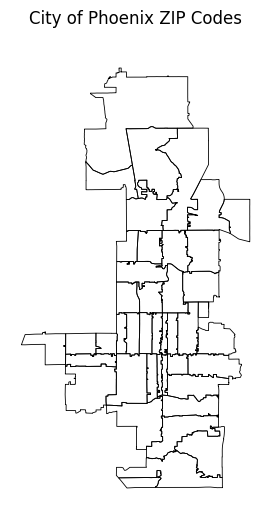

In [9]:
# Plot the GeoDataFrame
fig, ax = plt.subplots(figsize=(12, 6), dpi=100)

ax.set_title(f'City of Phoenix ZIP Codes')
Phoenix_zipcode_gdf.boundary.plot(ax=ax, facecolor='none', color="black", linewidth=0.6)
ax.axis('off')

# Show the entire figure
plt.savefig('Plots/Phoenix_Zips.jpeg', dpi=350)
plt.show()

In [10]:
# Get the Zip Census Demographics Data but filter for Arizona Zip Codes

def get_census_demographics_by_zip_df(print_col_info = True):
  csv_nm = 'ACS 2022 ZIP Merged Data.xlsx'
  zip_merged_census_data_df = pd.read_excel(other_data_folder + csv_nm)
  zip_merged_census_data_df = zip_merged_census_data_df[zip_merged_census_data_df['ZIP'].isin(AZ_zipcodes_list)]
  zip_merged_census_data_df['ZIP'] = zip_merged_census_data_df['ZIP'].astype(str)

  if(print_col_info):
      print_ln = "+" * 50
      print(f'{print_ln}\n')
      print('CSV NAME:', csv_nm)
      print(f"\ndf Shape: {zip_merged_census_data_df.shape}")
      print()
      print('Columns:\n--------------')

      for col, num in zip(zip_merged_census_data_df.columns, range(1, len(zip_merged_census_data_df))):
          print(f"{num}: {col}")

      print(f'\n{print_ln}')

  return(zip_merged_census_data_df)

zip_merged_census_data_df = get_census_demographics_by_zip_df()

++++++++++++++++++++++++++++++++++++++++++++++++++

CSV NAME: ACS 2022 ZIP Merged Data.xlsx

df Shape: (408, 40)

Columns:
--------------
1: Geography
2: ZIP
3: Geographic Area Name
4: Population by Education, 25 years and over High school graduate
5: Population by Education, 25 years and over Some College / Associates
6: Population by Education, 25 years and over Bachelor's or Higher
7: Employment, Civilian labor force 16 years and over Employed
8: Employment, Civilian labor force 16 years and over Unemployed
9: Population Worked full-time, year-round in the past 12 months
10: Population Worked less than full-time, year-round in the past 12 months
11: Population Did Not Work
12: Individuals Below Poverty Level
13: Individuals with Income Below 50% of the Poverty Level
14: Individuals with Income Below 125% of the Poverty Level
15: Total population
16: Male Population
17: Female Population
18: Population Under 5 years
19: Population 5 to 9 years
20: Population 10 to 14 years
21: Popula

In [11]:
# Represent the Population Census Data as Proportions of the Zip Code's Total Population
# --------------------------------------------------------------------------------------

leading_string = "Percentage "
start_pop_col_ind = 3
population_zip_census_data = zip_merged_census_data_df.iloc[:, start_pop_col_ind:]

# Remove non-numeric characters ('-') from the DataFrame
population_zip_census_data.replace('-', 0, inplace=True)

# Iterate through each column in the DataFrame
for column in population_zip_census_data.columns:
    if column != "Total population":
        # Calculate the proportion, replacing NaN with 0
        population_zip_census_data[leading_string + column] = population_zip_census_data[column].astype(float) / population_zip_census_data["Total population"].astype(float)
        # Drop the original column
        population_zip_census_data.drop(columns=[column], inplace=True)

# Print the updated DataFrame
zip_merged_census_data_df = pd.concat([zip_merged_census_data_df.iloc[:, :start_pop_col_ind], population_zip_census_data], axis=1)
display(zip_merged_census_data_df)

,Geography,ZIP,Geographic Area Name,Total population,"Percentage Population by Education, 25 years and over High school graduate","Percentage Population by Education, 25 years and over Some College / Associates","Percentage Population by Education, 25 years and over Bachelor's or Higher","Percentage Employment, Civilian labor force 16 years and over Employed","Percentage Employment, Civilian labor force 16 years and over Unemployed","Percentage Population Worked full-time, year-round in the past 12 months",...,Percentage Population One Race Black or African American,Percentage Population One Race American Indian and Alaska Native,Percentage Population One Race Asian,Percentage Population One Race Asian Indian,Percentage Population One Race Native Hawaiian and Other Pacific Islander,Percentage Population One Race Some Other Race,Percentage Population Two or More Races,"Percentage Population Two or More Races, White and Black or African American","Percentage Population Two or More Races, Black or African American and Some Other Race",Percentage Population Hispanic or Latino Any Race
29504,860Z200US84531,84531,ZCTA5 84531,606,0.349835,0.090759,0.026403,0.404290,0.019802,0.024752,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.021452,0.000000,0.000000,0.000000,0.000000
29509,860Z200US84536,84536,ZCTA5 84536,1419,0.307259,0.207893,0.045807,0.333333,0.066244,0.009161,...,0.000000,0.989429,0.000000,0.000000,0.000000,0.003524,0.000000,0.000000,0.000000,0.007047
29628,860Z200US85003,85003,ZCTA5 85003,9085,0.100495,0.132856,0.380958,0.521299,0.021244,0.235003,...,0.145845,0.026417,0.018712,0.010567,0.000000,0.021354,0.085636,0.000771,0.003632,0.285416
29629,860Z200US85004,85004,ZCTA5 85004,10548,0.090728,0.120307,0.350777,0.532234,0.037069,0.264031,...,0.054702,0.105328,0.060865,0.023132,0.000000,0.015074,0.151972,0.010903,0.001138,0.235969
29630,860Z200US85006,85006,ZCTA5 85006,24308,0.172371,0.147071,0.172001,0.506994,0.027686,0.139460,...,0.061502,0.029579,0.013370,0.001522,0.000658,0.025053,0.236013,0.013905,0.000535,0.594742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30041,860Z200US86544,86544,ZCTA5 86544,1440,0.249306,0.208333,0.036111,0.278472,0.025000,0.004167,...,0.000000,0.962500,0.003472,0.000000,0.008333,0.009722,0.015278,0.000000,0.000000,0.000000
30042,860Z200US86545,86545,ZCTA5 86545,1136,0.223592,0.173415,0.052817,0.255282,0.022887,0.019366,...,0.000000,0.979754,0.014965,0.014965,0.000000,0.012324,0.005282,0.000000,0.000000,0.004401
30043,860Z200US86547,86547,ZCTA5 86547,1044,0.182950,0.171456,0.026820,0.253831,0.049808,0.004789,...,0.000000,0.978927,0.000000,0.000000,0.000000,0.013410,0.021073,0.000000,0.000000,0.021073
30044,860Z200US86556,86556,ZCTA5 86556,2945,0.128353,0.138879,0.045501,0.167742,0.068930,0.027504,...,0.037012,0.865195,0.002716,0.001358,0.000000,0.015280,0.008829,0.000000,0.000000,0.031919


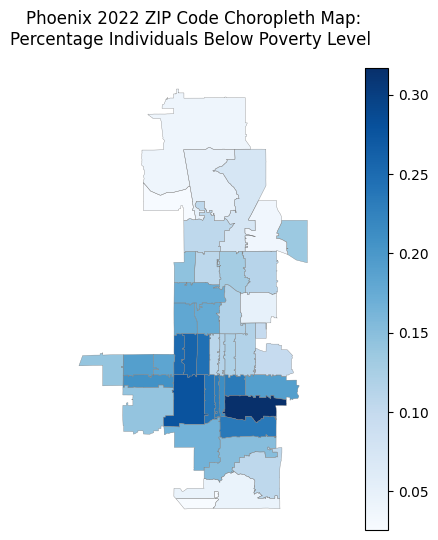

In [12]:
# Plot Any Census Metric by City of Phoenix Zipcode

# Plot the GeoDataFrame
fig, ax = plt.subplots(figsize=(12, 6), dpi=100)

def plot_census_metric_by_phoenix_zipcode(metric, ax = ax, the_cmap = 'Blues', print_top_vals = False,
                                          vmin = None, vmax = None, char_limit = 41):
  census_metric_zip_df = zip_merged_census_data_df[['ZIP', metric]]

  census_metric_zip_gdf = AZ_zipcode_gdf.merge(census_metric_zip_df, on='ZIP', how='left')

  plot_metric_title = split_string_recursive(metric, char_limit)

  # filter for CO Phoenix zipcodes
  census_metric_zip_gdf = census_metric_zip_gdf[census_metric_zip_gdf['ZIP'].isin(CO_Phoenix_zips_list)]
  census_metric_zip_gdf.reset_index(drop=True, inplace=True)

  census_metric_zip_gdf.plot(column = metric,
                                cmap = the_cmap,
                                legend = True,
                                ax = ax, vmin = vmin, vmax = vmax)
  ax.set_title(f'Phoenix 2022 ZIP Code Choropleth Map:\n{plot_metric_title} ')
  Phoenix_zipcode_gdf.boundary.plot(ax=ax, facecolor='none', color="grey", linewidth=0.25)
  ax.axis('off')

  if print_top_vals:
    print("Top Values:\n------------")
    print(census_metric_zip_gdf[[metric, 'ZIP']].sort_values(by=metric, ascending=False).head(5))

# For splitting long strings and adding '\n' to create a multi-line string
def split_string_recursive(stringg, char_limit = 41):
    # Base case: if the string length is less than the character limit, return the string
    if len(stringg) <= char_limit:
        return stringg

    # Split the string into two parts at the character limit
    chunk1 = stringg[:char_limit]
    chunk2 = stringg[char_limit:]

    # Recursively split the second part of the string
    rest_of_stringg = split_string_recursive(chunk2, char_limit)

    # Concatenate the first chunk with the result of the recursive call
    return chunk1 + '\n' + rest_of_stringg

plot_census_metric_by_phoenix_zipcode(f'{leading_string}Individuals Below Poverty Level', ax = ax, the_cmap = 'Blues', char_limit = 42)

In [13]:
# Get the cleaned UOF data

uof_path_folder = 'CPhoenix UOF Data/'
data_relabeled_filepaths_cleaned = glob.glob(f'{uof_path_folder}relabeled/cleaned*.csv', recursive = True) # includes the cleaned columns

def get_cleaned_uof_incident_details_df(which, print_cleaned_col_info = True):
    if which not in range(1, len(data_relabeled_filepaths_cleaned) + 1):
        raise ValueError(f"Parameter must be in range [1, {len(data_relabeled_filepaths_cleaned)}].")

    for filepath in data_relabeled_filepaths_cleaned:
      if f'cleaned_{which}' in filepath:
          cleaned_main_path = filepath
          break

    cleaned_main = pd.read_csv(cleaned_main_path)

    if(print_cleaned_col_info):
        print_ln = "+" * 50
        print(f'{print_ln}\n')
        print('CSV NAME:', cleaned_main_path.rsplit('/', 1)[-1][:-4])
        print(f"\ndf Shape: {cleaned_main.shape}")
        print()
        print('Columns:\n--------------')

        for col, num in zip(cleaned_main.columns, range(1, len(cleaned_main))):
            print(f"{num}: {col}")

        print(f'\n{print_ln}')

    return(cleaned_main)

cleaned_main_uof_df = get_cleaned_uof_incident_details_df(1)

++++++++++++++++++++++++++++++++++++++++++++++++++

CSV NAME: cleaned_1-uof-incident-details

df Shape: (4967, 55)

Columns:
--------------
1: Use of Force Report Number
2: Incident Report Number
3: Police Employee Unique Identifier
4: Unique Individual Record Number 
5: Date
6: Year
7: Hour
8: Day of Week
9: Police Beat
10: Anonymized Address
11: City
12: State
13: Zip Code
14: Police Precinct
15: Individual Injury
16: Individual Gender
17: Individual Age
18: Individual Age Grouped
19: Individual Race
20: Individual  Ethnicity
21: Individual Race / Ethnicity Grouping
22: Police Employee Race / Ethnicity Grouping
23: Police Employee Gender / Sex
24: Individual Resistance - Aggravated Active Aggression
25: Individual Resistance -Active Aggression
26: Individual Resistance -Active Resistance
27: Individual Resistance -Passive Resistance
28: Individual Resistance -Psychological Intimidation
29: Individual Resistance -Verbal Non Compliance
30: Individual Resistance - None
31: Individual Ar

In [14]:
# Plot UOF Sum by Zip Code Map -- And against some other Census Metric
# ----------------------------------------------------------------------

uof_zip_df = cleaned_main_uof_df.copy()

# Create a column that totals the # of types of UOF used for each record
column_filter_like = 'Use of Force Utilized - Pointed Gun at Person'
column_filter_like = 'Use of Force Utilized'
aggregate_col_name = f'\'{column_filter_like}\' Sum'

uof_zip_df[aggregate_col_name] = uof_zip_df.filter(like=column_filter_like).sum(axis=1)
uof_zip_df = uof_zip_df[['Zip Code', aggregate_col_name]]
uof_zip_df.loc[:, 'Zip Code'] = uof_zip_df['Zip Code'].astype(str).str.rstrip('.0')
uof_zip_df.rename(columns={'Zip Code': 'ZIP'}, inplace=True)

# group all of the zipcodes and total all of the UOF totals, to get UOF sums by zipcode
sum_uof_zip_df = uof_zip_df.groupby('ZIP')[aggregate_col_name].sum().reset_index()

# filter for CO Phoenix zipcodes
sum_uof_zip_df = sum_uof_zip_df[sum_uof_zip_df['ZIP'].isin(CO_Phoenix_zips_list)]

# fill in any missing Zip codes with 0
sum_uof_zip_df = (sum_uof_zip_df.merge(Phoenix_zipcode_gdf['ZIP'], on='ZIP', how='right'))
sum_uof_zip_df.fillna(0, inplace=True)

sum_uof_zip_gdf = Phoenix_zipcode_gdf.merge(sum_uof_zip_df, on='ZIP', how='left')

# alters the aggregate value to represent the sum adjusted for population size.
make_sum_proportion = True

if make_sum_proportion:
  # Represent UOF Sum as a proportion of each Zip Code's population size

  sum_prop_uof_zip_gdf = sum_uof_zip_gdf.merge(zip_merged_census_data_df[['ZIP', 'Total population']], on='ZIP', how='left')
  sum_prop_uof_zip_gdf['Force Incidents per Capita'] = sum_prop_uof_zip_gdf[aggregate_col_name] / sum_prop_uof_zip_gdf['Total population']
  sum_prop_uof_zip_gdf.drop(columns=[aggregate_col_name, 'Total population'], inplace=True)

  # alter values accordingly
  sum_uof_zip_gdf = sum_prop_uof_zip_gdf
  aggregate_col_name = 'Force Incidents per Capita'
  sum_uof_zip_df = sum_uof_zip_gdf[['ZIP', aggregate_col_name]]

# Print the top counties by UOF Utilized Sum
top_x_zips = 5
top_zips_uof_sum_df = sum_uof_zip_df.sort_values(by = aggregate_col_name, ascending=False).head(top_x_zips)
print(f"Top {top_x_zips} City of Phoenix Zip Codes by {aggregate_col_name}:\n--------------------------------------------------")
display(top_zips_uof_sum_df)


Top 5 City of Phoenix Zip Codes by Force Incidents per Capita:
--------------------------------------------------


,ZIP,Force Incidents per Capita
38,85034,0.045408
25,85012,0.011307
24,85015,0.009602
6,85006,0.009338
7,85017,0.008629


In [15]:
# Get the City of Phoenix crime data

phoenix_crime_df = pd.read_csv(other_data_folder + 'city_of_phoenix_crime_data-cleaned')

crime_types = ['LARCENY-THEFT', 'RAPE', 'ROBBERY', 'BURGLARY',
       'MOTOR VEHICLE THEFT', 'AGGRAVATED ASSAULT', 'DRUG OFFENSE',
       'ARSON', 'MURDER AND NON-NEGLIGENT MANSLAUGHTER']

crime_count_by_zips = pd.concat([phoenix_crime_df,
           pd.get_dummies(phoenix_crime_df['Uniform Crime Reporting (UCR) crime type'])],
           axis=1).groupby('ZIP')[crime_types].sum().reset_index()

crime_count_by_zips = crime_count_by_zips.merge(Phoenix_zipcode_gdf['ZIP'].astype(float), how = 'right', on = 'ZIP').reset_index(drop=True)

crime_count_by_zips = crime_count_by_zips.merge(zip_merged_census_data_df[['ZIP', 'Total population']].astype(float), on='ZIP', how='left')

for type_c in crime_types:
  crime_count_by_zips['Per Capita Count ' + type_c.lower()] = crime_count_by_zips[type_c] / crime_count_by_zips['Total population']

crime_count_by_zips.drop(columns = crime_types + ['Total population'], inplace=True)
crime_count_by_zips['ZIP'] = crime_count_by_zips['ZIP'].astype(str).str[:-2]

crime_count_by_zips.head(3)

,ZIP,Per Capita Count larceny-theft,Per Capita Count rape,Per Capita Count robbery,Per Capita Count burglary,Per Capita Count motor vehicle theft,Per Capita Count aggravated assault,Per Capita Count drug offense,Per Capita Count arson,Per Capita Count murder and non-negligent manslaughter
0,85086,0.013900,0.000228,0.000273,0.002028,0.001869,0.001185,0.000205,0.000091,0.000023
1,85027,0.106431,0.003448,0.003371,0.018390,0.022834,0.015172,0.014099,0.001609,0.000409
2,85048,0.041873,0.001411,0.001617,0.008645,0.006234,0.004411,0.003088,0.000559,0.000029


In [16]:
# Get the correlation between Use of Force used and Census Metrics
# ------------------------------------------------------------------

zip_census_data_uof_corr_df = zip_merged_census_data_df.merge(sum_uof_zip_df, on='ZIP', how='left')
zip_census_data_uof_corr_df = zip_census_data_uof_corr_df.merge(crime_count_by_zips, on='ZIP', how = 'left')
zip_census_data_uof_corr_df.drop(columns=["Geography", "Geographic Area Name", "ZIP"], inplace=True)
zip_census_data_uof_corr_df.dropna(inplace=True)

# Move the column "UOF Utilized Sum" to the front
uof_utilized_sum_column = zip_census_data_uof_corr_df.pop(aggregate_col_name)
zip_census_data_uof_corr_df.insert(0, aggregate_col_name, uof_utilized_sum_column)

# Compute the correlation matrix
correlation_matrix = zip_census_data_uof_corr_df.corr(numeric_only = True)

correlation_name = f'Correlation with {aggregate_col_name}'

# Compute the correlation between the first column ("UOF Utilized Sum") and all other columns
correlation_with_first_column = correlation_matrix.iloc[0, :].to_frame(name=correlation_name)

# Sort the correlation series in descending order
sorted_correlations = correlation_with_first_column.reindex(correlation_with_first_column[correlation_name].abs().sort_values(ascending=False).index)

# Filter for correlations greater than or equal to 0.3
filtered_correlations = sorted_correlations[sorted_correlations[correlation_name].abs() >= 0.3]

display(filtered_correlations.head(10))

,Correlation with Force Incidents per Capita
Force Incidents per Capita,1.000000
Per Capita Count robbery,0.941591
Per Capita Count motor vehicle theft,0.931487
Per Capita Count larceny-theft,0.928882
Per Capita Count burglary,0.917525
Per Capita Count drug offense,0.916780
Per Capita Count aggravated assault,0.888310
Per Capita Count murder and non-negligent manslaughter,0.858786
Per Capita Count arson,0.839571
Per Capita Count rape,0.711209


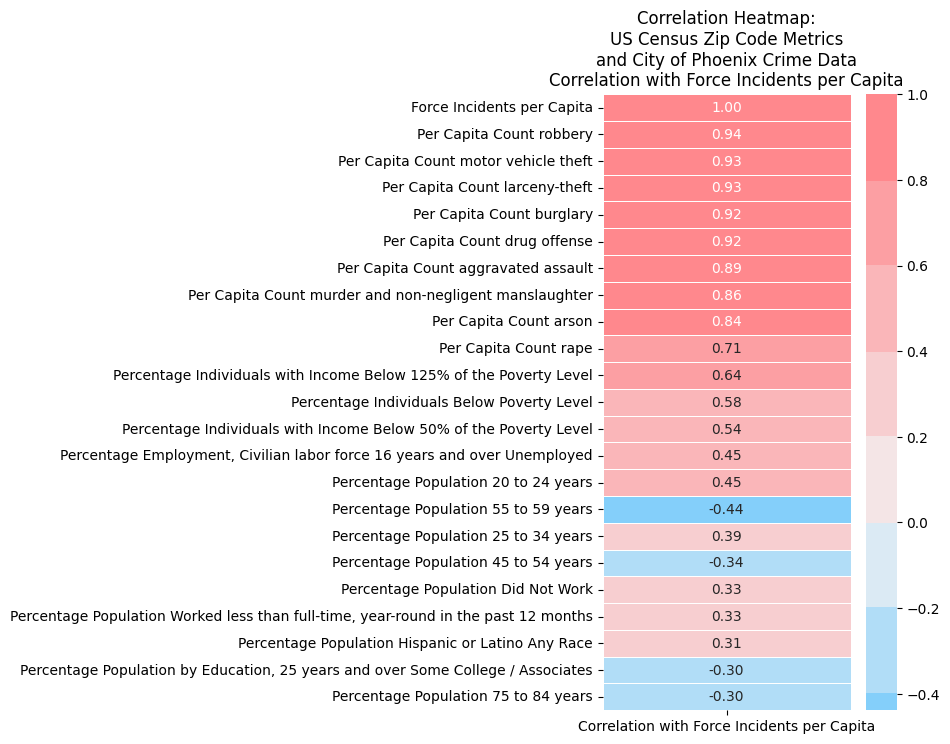

In [17]:
# Plot the correlations as a Heatmap

# custom colormap for correlation heatmap
my_custom_cmap = sns.diverging_palette(240, 10, s=100, l=70, n=10)

# Create the heatmap with positive and negative values
plt.figure(figsize=(4, 8), dpi=100)

# Create subplots with custom gridspec_kw to adjust left margin
#gs = plt.GridSpec(1, 1, left=0.8, right=3)  # Adjust left and right margins as needed
#ax = plt.subplot(gs[0])

sns.heatmap(filtered_correlations, annot=True, cmap=my_custom_cmap, linewidths=.5, fmt=".2f", center=0)
plt.title(f'Correlation Heatmap:\nUS Census Zip Code Metrics\nand City of Phoenix Crime Data\n{correlation_name}')
#plt.savefig('Plots/census_zip_correlation_heat_map.jpeg', dpi=350)
plt.show()


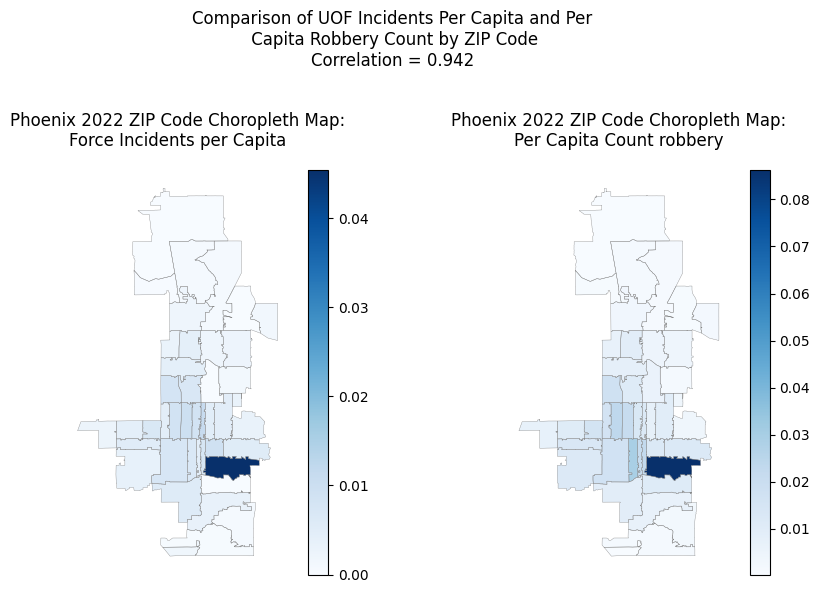

In [18]:
fig, ax = plt.subplots(figsize=(9, 6), ncols=2, dpi=100)

the_cmap = 'Blues'

sum_uof_zip_gdf.plot(column=aggregate_col_name,
                     cmap= the_cmap,
                     legend=True,
                     missing_kwds={'color': 'lightgrey'},
                     ax=ax[0])  # Set the first subplot as ax[0]
ax[0].set_title(f'Phoenix 2022 ZIP Code Choropleth Map:\n{aggregate_col_name}')
Phoenix_zipcode_gdf.boundary.plot(ax=ax[0], facecolor='none', color="grey", linewidth=0.25)
ax[0].axis('off')

crime_col_nm = 'Per Capita Count robbery'
crime_count_by_zips_gdf = sum_uof_zip_gdf.merge(crime_count_by_zips, on = 'ZIP', how = 'left')
crime_count_by_zips_gdf = crime_count_by_zips_gdf[['geometry', crime_col_nm]]

crime_count_by_zips_gdf.plot(column = crime_col_nm,
                     cmap= the_cmap,
                     legend=True,
                     ax=ax[1])
ax[1].set_title(f'Phoenix 2022 ZIP Code Choropleth Map:\n{crime_col_nm}')
Phoenix_zipcode_gdf.boundary.plot(ax=ax[1], facecolor='none', color="grey", linewidth=0.25)
ax[1].axis('off')

# Add super plot title

the_suptitle = split_string_recursive(f'Comparison of UOF Incidents Per Capita and Per Capita Robbery Count by ZIP Code',
                                    char_limit=46)
the_suptitle += f'\nCorrelation = {round(filtered_correlations.loc[crime_col_nm][0], 3)}'
fig.suptitle(the_suptitle, fontsize=12)

# Adjust layout to accommodate super title
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the entire figure
plt.savefig('Plots/by_zip_uof_sum_against_crime_data.jpeg', dpi=350)
plt.show()

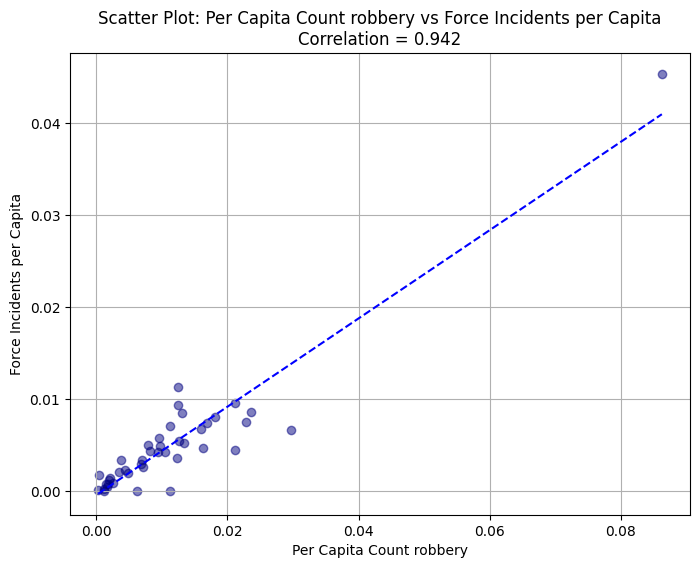

In [19]:
from scipy.stats import linregress

# Scatter plot for 'Per Capita Count robbery'
plt.figure(figsize=(8, 6))
plt.scatter(crime_count_by_zips_gdf['Per Capita Count robbery'], sum_uof_zip_gdf['Force Incidents per Capita'], c='navy', alpha=0.5)
the_title = f'Scatter Plot: Per Capita Count robbery vs Force Incidents per Capita'
the_title += f'\nCorrelation = {round(filtered_correlations.loc[crime_col_nm][0], 3)}'

plt.title(the_title)

plt.xlabel('Per Capita Count robbery')
plt.ylabel('Force Incidents per Capita')
plt.grid(True)

# Calculate the trend line using linear regression
slope, intercept, r_value, p_value, std_err = linregress(crime_count_by_zips_gdf['Per Capita Count robbery'], sum_uof_zip_gdf['Force Incidents per Capita'])
x_values = np.array([min(crime_count_by_zips_gdf['Per Capita Count robbery']), max(crime_count_by_zips_gdf['Per Capita Count robbery'])])
y_values = slope * x_values + intercept

# Plot the trend line
plt.plot(x_values, y_values, color='blue', linestyle='--', label=f'Trend Line (y={slope:.2f}x+{intercept:.2f})')

plt.savefig('Plots/by_zip_uof_sum_against_crime_data_scatter.jpeg', dpi=350)

plt.show()

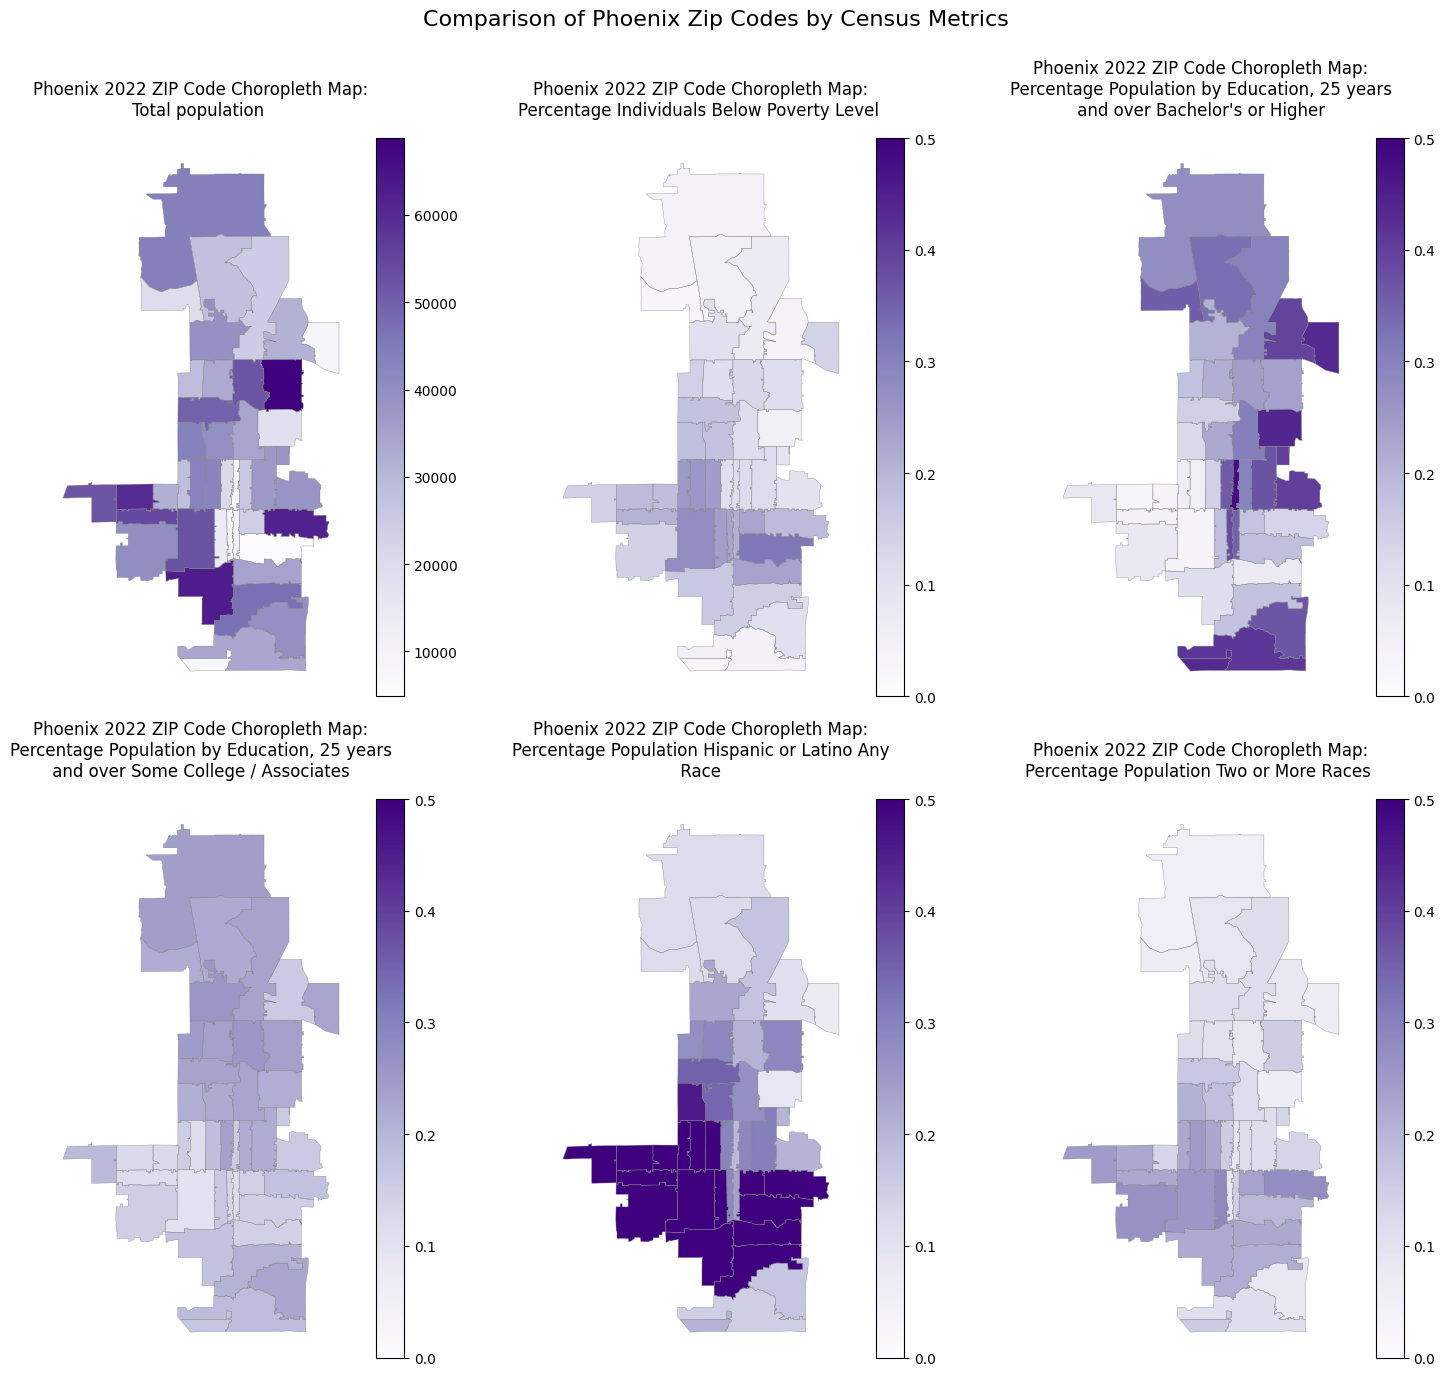

In [21]:
items_plot = ['Total population',
              f'{leading_string}Individuals Below Poverty Level',
              f'{leading_string}Population by Education, 25 years and over Bachelor\'s or Higher',
              f'{leading_string}Population by Education, 25 years and over Some College / Associates',
              f'{leading_string}Population Hispanic or Latino Any Race',
              f'{leading_string}Population Two or More Races']

the_cmap = 'Purples'
fig, ax = plt.subplots(2, 3, figsize=(15, 14), dpi = 100)
ax = ax.flatten()

for i, item in zip(range(len(ax)), items_plot):
  if item == 'Total population':
    vmin = None; vmax = None
  else:
    vmin = 0; vmax = 0.5
  plot_census_metric_by_phoenix_zipcode(metric = item,
                                        ax = ax[i], the_cmap = the_cmap,
                                        vmin = vmin, vmax = vmax, char_limit = 44)
# Add super plot title
the_suptitle = split_string_recursive(f'Comparison of Phoenix Zip Codes by Census Metrics',
                                    char_limit=50)
fig.suptitle(the_suptitle, fontsize=16)

# Adjust layout to accommodate super title
plt.tight_layout(rect=[0, 0, 1, 0.98])

# Save the plot to file
plt.savefig('Plots/zip_choropleths.jpeg', dpi = 350)

In [22]:
# filter for CO Phoenix zipcodes
population_zip_census_data = zip_merged_census_data_df[zip_merged_census_data_df['ZIP'].isin(CO_Phoenix_zips_list)]
population_zip_census_data.reset_index(drop=True, inplace=True)

population_zip_census_data = population_zip_census_data.filter(like=leading_string)
pop_column_averages = population_zip_census_data.mean()
print("Top Proportions (Avg):\n---------------------")
pop_column_averages.sort_values(ascending=False).head(10)

Top Proportions (Avg):
---------------------


Percentage Employment, Civilian labor force 16 years and over Employed             0.513485
Percentage Male Population                                                         0.505621
Percentage Female Population                                                       0.494379
Percentage Population Hispanic or Latino Any Race                                  0.393364
Percentage Population by Education, 25 years and over Bachelor's or Higher         0.235015
Percentage Individuals with Income Below 125% of the Poverty Level                 0.194229
Percentage Population by Education, 25 years and over Some College / Associates    0.188144
Percentage Population 25 to 34 years                                               0.168537
Percentage Population Two or More Races                                            0.158930
Percentage Individuals Below Poverty Level                                         0.149135
dtype: float64

## Look at Crime Over Time Vs Use of Force

In [23]:
cleaned_main_uof_df_2 = get_cleaned_uof_incident_details_df(2)
cleaned_main_uof_df_2 = cleaned_main_uof_df_2[cleaned_main_uof_df_2['Year'].isin(range(2018, 2024))]

++++++++++++++++++++++++++++++++++++++++++++++++++

CSV NAME: cleaned_2-uof-incident-details

df Shape: (8629, 40)

Columns:
--------------
1: Incident Report Number
2: Police Employee Unique Identifier
3: Unique Individual Record Number 
4: Date
5: Year
6: Hour
7: Day of Week
8: Police Beat
9: Anonymized Address
10: Police Precinct
11: Individual Gender
12: Individual Age
13: Individual Age Grouped
14: Individual Race
15: Individual  Ethnicity
16: Individual Race / Ethnicity Grouping
17: Police Employee Race / Ethnicity Grouping
18: Police Employee Gender / Sex
19: Individual Resistance - Aggravated Active Aggression
20: Individual Resistance -Active Aggression
21: Individual Resistance -Active Resistance
22: Individual Resistance -Passive Resistance
23: Individual Resistance -Psychological Intimidation
24: Individual Resistance -Verbal Non Compliance
25: Individual Resistance - None
26: Individual Armed With -Gun
27: Individual Armed with - Cutting Instrument
28: Individual Armed Wit

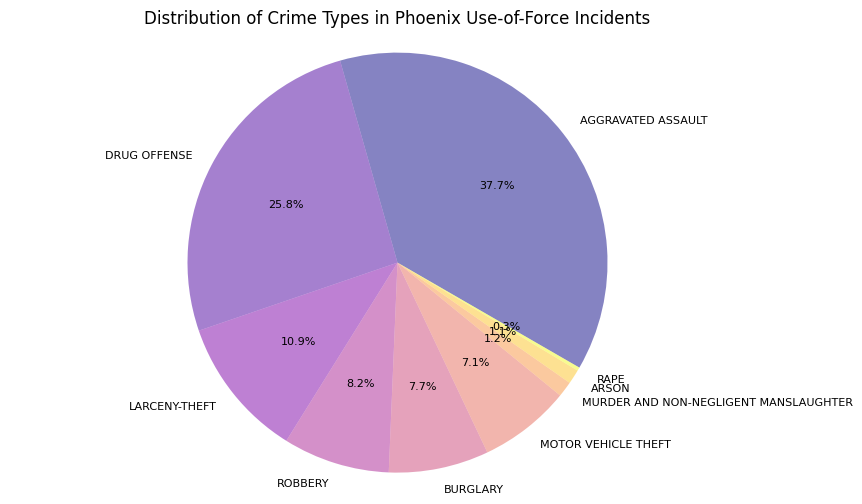

In [24]:

uof_crime_df = cleaned_main_uof_df_2.copy().merge(phoenix_crime_df, how='inner', left_on='Incident Report Number', right_on='Crime Incident Number')

# Get value counts of the column
crime_type_counts = uof_crime_df['Uniform Crime Reporting (UCR) crime type'].value_counts()

# Generate custom colors from the 'plasma' colormap
num_colors = len(crime_type_counts)
colors = plt.cm.plasma(np.linspace(0, 1, num_colors))

# Adjust the opacity of colors
colors_with_opacity = [(r, g, b, 0.5) for r, g, b, _ in colors]  # Alpha value of 0.5 (50% opacity)

# Plot a pie chart with custom colors and adjusted opacity
plt.figure(figsize=(10, 6), dpi = 100)
plt.pie(crime_type_counts, labels=crime_type_counts.index, autopct='%1.1f%%', startangle=-30,
        colors=colors_with_opacity,
        textprops={'color': 'black', 'fontsize':'8'})
plt.title('Distribution of Crime Types in Phoenix Use-of-Force Incidents')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Save the plot to file
plt.savefig('Plots/uof_crime_types_pie.jpeg', dpi = 350)

plt.show()

In [26]:
## GET UOF COUNTS
column_filter_like = 'Use of Force Utilized'
aggregate_col_name = f'\'{column_filter_like}\' Sum'

uof_df = cleaned_main_uof_df_2.copy()
total_incidents = uof_df.shape[0]
uof_df[aggregate_col_name] = uof_df.filter(like=column_filter_like).sum(axis=1)
uof_year_counts = uof_df.groupby('Year')[aggregate_col_name].sum()

# Convert the series to a DataFrame
uof_year_counts_df = pd.DataFrame({'UOF Total Incidents': uof_year_counts})

uof_year_counts_df['UOF Total Incidents Proportion'] = uof_year_counts_df['UOF Total Incidents'] / cleaned_main_uof_df_2.shape[0]

## GET CRIME COUNTS
phoenix_crime_df_2 = phoenix_crime_df.copy()
phoenix_crime_df_2['Year'] = phoenix_crime_df_2['Earliest Date and Time of Occurrence of Crime'].str[:4].astype(int)
phoenix_crime_df_2 = phoenix_crime_df_2[phoenix_crime_df_2['Year'].isin(range(2018, 2024))]

crime_year_counts = phoenix_crime_df_2.groupby('Year').count()['Crime Incident Number']

# Convert the series to a DataFrame
crime_year_counts_df = pd.DataFrame({'Crime Total Incidents': crime_year_counts})
total_incidents_sum = crime_year_counts_df['Crime Total Incidents'].sum()

crime_year_counts_df['Crime Total Incidents Proportion'] = crime_year_counts_df['Crime Total Incidents'] / total_incidents_sum

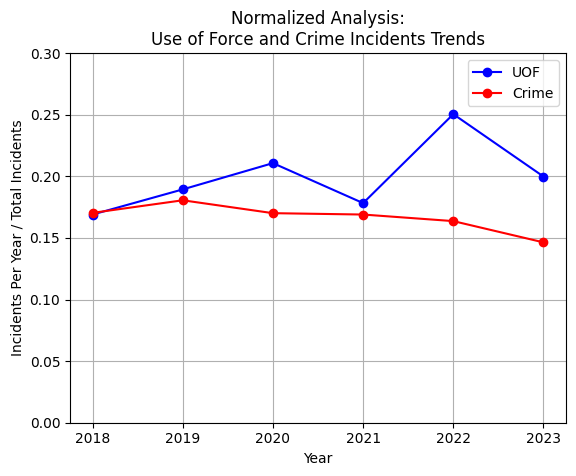

In [33]:
# Plot 'UOF Total Incidents Proportion'
plt.plot(uof_year_counts_df['UOF Total Incidents Proportion'], marker='o', linestyle='-', label='UOF', color = 'blue')
# Plot 'Crime Total Incidents Proportion'
plt.plot(crime_year_counts_df['Crime Total Incidents Proportion'], marker='o', linestyle='-', label='Crime', color = 'red')

# Set the title and labels
plt.title('Normalized Analysis:\nUse of Force and Crime Incidents Trends')
plt.xlabel('Year')
plt.ylabel('Incidents Per Year / Total Incidents')

# Add legend
plt.legend()
plt.ylim(0, 0.3)

# Show the plot
plt.grid(True)

# Save the plot to file
plt.savefig('Plots/uof_and_crime_over_time.jpeg', dpi = 350)

plt.show()